# Practical Session on Graph Neural Networks

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 90.4 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 31.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning).

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [3]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [4]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [5]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [6]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [7]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6386
F1-Score: 0.4456
Epoch 00002 | Loss: 0.5828
Epoch 00003 | Loss: 0.5626
Epoch 00004 | Loss: 0.5563
Epoch 00005 | Loss: 0.5515
Epoch 00006 | Loss: 0.5465
F1-Score: 0.4911
Epoch 00007 | Loss: 0.5418
Epoch 00008 | Loss: 0.5375
Epoch 00009 | Loss: 0.5343
Epoch 00010 | Loss: 0.5317
Epoch 00011 | Loss: 0.5288
F1-Score: 0.5307
Epoch 00012 | Loss: 0.5261
Epoch 00013 | Loss: 0.5236
Epoch 00014 | Loss: 0.5212
Epoch 00015 | Loss: 0.5190
Epoch 00016 | Loss: 0.5169
F1-Score: 0.5183
Epoch 00017 | Loss: 0.5147
Epoch 00018 | Loss: 0.5126
Epoch 00019 | Loss: 0.5104
Epoch 00020 | Loss: 0.5079
Epoch 00021 | Loss: 0.5057
F1-Score: 0.5284
Epoch 00022 | Loss: 0.5038
Epoch 00023 | Loss: 0.5018
Epoch 00024 | Loss: 0.4998
Epoch 00025 | Loss: 0.4980
Epoch 00026 | Loss: 0.4963
F1-Score: 0.5404
Epoch 00027 | Loss: 0.4944
Epoch 00028 | Loss: 0.4924
Epoch 00029 | Loss: 0.4907
Epoch 00030 | Loss: 0.4889
Epoch 00031 | Loss: 0.4872
F1-Score: 0.5476
Epoch 00032 | Loss: 0.4853
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6572


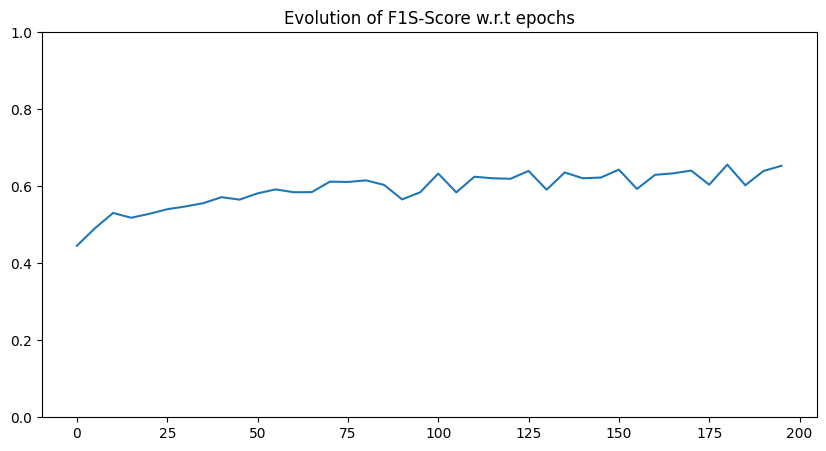

In [8]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [9]:
import torch.nn.functional as F

class StudentModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_heads=5, dropout=0, n_layers=4
    ):
        super().__init__()
        self.layers = nn.ModuleList()
        self.nonlinearity = F.leaky_relu

        # First GATConv layer
        self.layers.append(
            graphnn.GATConv(input_size, hidden_size, heads=num_heads, dropout=dropout)
        )

        # Other GATConv layers
        for _ in range(1, n_layers - 1):
            self.layers.append(
                graphnn.GATConv(
                    hidden_size * num_heads,
                    hidden_size,
                    heads=num_heads,
                    dropout=dropout,
                )
            )

        # Final linear layer
        self.layers.append(nn.Linear(hidden_size * num_heads, output_size))

    def forward(self, x, edge_index):
        for _, layer in enumerate(self.layers[:-1]):
            x = self.nonlinearity(layer(x, edge_index))
        x = self.layers[-1](x)
        return x

Let's train your model !

In [10]:
## Student model
student_model = StudentModel(input_size=n_features, hidden_size=350, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.6718
F1-Score: 0.4242
Epoch 00002 | Loss: 0.5634
Epoch 00003 | Loss: 0.5570
Epoch 00004 | Loss: 0.5519
Epoch 00005 | Loss: 0.5511
Epoch 00006 | Loss: 0.5447
F1-Score: 0.3858
Epoch 00007 | Loss: 0.5425
Epoch 00008 | Loss: 0.5353
Epoch 00009 | Loss: 0.5350
Epoch 00010 | Loss: 0.5278
Epoch 00011 | Loss: 0.5254
F1-Score: 0.4748
Epoch 00012 | Loss: 0.5217
Epoch 00013 | Loss: 0.5172
Epoch 00014 | Loss: 0.5076
Epoch 00015 | Loss: 0.5041
Epoch 00016 | Loss: 0.4955
F1-Score: 0.5235
Epoch 00017 | Loss: 0.4972
Epoch 00018 | Loss: 0.4883
Epoch 00019 | Loss: 0.4824
Epoch 00020 | Loss: 0.4778
Epoch 00021 | Loss: 0.4724
F1-Score: 0.5659
Epoch 00022 | Loss: 0.4719
Epoch 00023 | Loss: 0.4739
Epoch 00024 | Loss: 0.4681
Epoch 00025 | Loss: 0.4581
Epoch 00026 | Loss: 0.4496
F1-Score: 0.6014
Epoch 00027 | Loss: 0.4398
Epoch 00028 | Loss: 0.4340
Epoch 00029 | Loss: 0.4297
Epoch 00030 | Loss: 0.4276
Epoch 00031 | Loss: 0.4324
F1-Score: 0.6231
Epoch 00032 | Loss: 0.4292
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.9803


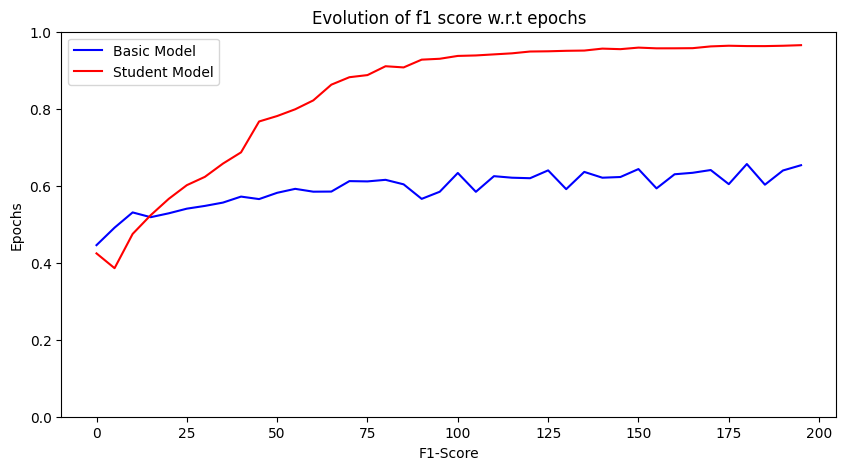

In [11]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

><font color="blue"> 1. **Architecture and choices:** We used a neural network composed of 3 GAT layers with Leaky ReLu as the activation function, and a final linear layer. The reason why we decided to use this kind of layers is that they can achieve better results with more simple architectures according to the state-of-the-art [4][5].

><font color="blue">Through experimentation with architectures of 2, 3 and 4 GAT layers, the configuration with 3 GAT layers emerged as the most performing. We tested GAT hidden sizes of 200, 250, 300, 350, 400 and 450, which allowed us to see that 350 was the best choice. We tried with 1, 2, 3, 4 and 5 heads, noticing that 5 was the choice with a higher F1-Score. We also evaluated ELU and ReLu activation functions, but both resulted in inferior performance compared to Leaky ReLU. We trained the model for 200 epochs. While it was feasible to extend the training, we decided to mantain the same number of epochs used in the baseline model for a direct comparison. For the learning rate, we tried several values between 0.001 and 0.01, and we found that 0.005 was a good learning rate. Finally, we found that setting the dropout rate to 0 was the best choice, since including dropout resulted in a worse performance of our model.

><font color="blue"> **Why is it more efficient than the Basic Model?** Graph Attention Networks (GATs) utilize attention mechanisms to assign dynamic weights to the features of neighboring nodes. This process enables GATs to prioritize more significant information for each node, resulting in more flexible representations. On the other hand, Graph Convolutional Networks (GCNs) use a uniform aggregation method, which may mix less pertinent information, weakening the influence of key neighbors. GATs' ability to adapt their focus according to the relevance of information makes them more effective across a variety of graph structures, thus improving their performance on different tasks.

><font color="blue"> 2. **Analysis of our results**

><font color="blue"> **What is the F1-Score ?** The F1-Score is a metric used to evaluate the accuracy of a binary classification model, combining precision and recall into a single measure. It is the harmonic mean of precision (the proportion of true positive results in all positive predictions) and recall (the proportion of true positive results in all actual positives). The F1-Score ranges from 0 to 1, where 1 indicates perfect precision and recall, and 0 means the model failed both. It's especially useful when the classes are imbalanced, because it balances the trade-off between precision and recall. It is also useful in scenarios where identifying true positives is as important as minimizing false positives and negatives.

><font color="blue">  **Are your results convincing ?** The model's F1-Score shows that after 200 epochs, the metric is very close to 1, demonstrating a good ability to balance precision and recall, which indicates that the model is effective at making correct predictions and thus it is reliable. Also, the log-shaped progression of the F1-Score suggests that while further impprovements are possible, significant gains might require a larger number of epochs.

><font color="blue">  **What is your position w.r.t state-of-the-art ?** This kind of architecture was presented in 2018, and at that time it was achieving the best results on the PPI dataset [4]. Now, there are some architectures with better performances (although usually they are also based on GAT layers). For instance, the architecture presented on [5], which was made by a combination of GCN layers, GAT layers and pooling layers, achieves a F1-Score of 0.9887 after training for only 50 epochs on the same dataset, which is not far from our score.

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ?
2. Are there solutions to overcome it ?
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

> <font color="blue"> 1. According to [1], oversmoothing in Graph Neural Networks (GNNs) occurs when node features become too similar after multiple layers of processing, causing a loss of distinctive information. This happens because each layer of a GNN aggregates information from a node's neighbors, and with many layers, nodes end up sharing too much information, losing their unique characteristics. Oversmoothing is problematic because it degrades the performance of GNNs on tasks like node classification by making it harder to distinguish between nodes. It limits the depth of GNNs since beyond a certain number of layers, adding more layers does not improve but rather worsens performance.

> <font color="blue"> 2. Yes, there are several solutions to overcome it. Once again according to [1], several recent methods include Normalization and Regularization (penalizing deviations of over-smoothing measures during
training, normalizing the node feature embeddings or adding noise to the optimization process), change of GNN dynamics (for example, the use
of non-linear oscillators which are coupled through the graph structure yielding Graph-Coupled Oscillator Network [2]) and residual connections. Other solutions are also possible such as the one explained in [3], which addresses oversmoothing by incorporating node relation information, such as absolute differences and element-wise products of node embeddings, to emphasize differences between nodes and prevent their embeddings from becoming indistinguishable.


> <font color="blue"> 3. Yes, we think the model we constructed is more robust to over-smoothing, because GATConv layers are trying to learn node representations by weighting the importance of each neighbor's features differently (and also the importance of the node's own features, as it is clarified in [4]). We believe that this approach can mitigate the oversmoothing effect, because it allows the model to emphasize significant neighbors while discarding less pertinent information, unlike graph convolutional layers that uniformly distribute information about all neighbors, potentially leading to feature homogeniation after multiple layers. Also, the model has potential for self-regularizing oversmoothing, since it has the hability to assign greater weight to the node itself as needed, if the model's performance starts to decrease during training.

> <font color="blue"> At the same time, the fact that our architecture is able to achieve good results with only three GATConv layers is also helping to mitigate oversmoothing, because other operations may require more layers, which may induce feature homogenization.

<font color="blue"> **References:**

<font color="blue"> [1] T. Konstantin Rusch, Michael M. Bronstein, Siddhartha Mishra, *A survey on oversmoothing in Graph Neural Networks*, https://arxiv.org/pdf/2303.10993.pdf

<font color="blue"> [2] T. Rusch et al., *Graph-Coupled Oscillator Networks*, https://arxiv.org/pdf/2202.02296.pdf

<font color="blue"> [3] Y. Koishekenov, *Reducing Over-smoothing in Graph Neural Networks Using Relational Embeddings*, https://arxiv.org/pdf/2301.02924.pdf

<font color="blue"> [4] P. Velickovic, G. Cucurull, A. Casanova, A. Romero, P. Lio, Y. Bengio, *Graph Attention Networks*, https://arxiv.org/pdf/1710.10903.pdf

<font color="blue"> [5] K. Jha, S. Saha, H. Singh, *Prediction of protein-protein
interaction using graph neural
networks*, https://www.nature.com/articles/s41598-022-12201-9
